In [2]:
from phantoms.utils.CKA.cka_plots import plot_inter_model_cka, plot_aggregated_inter_model_cka_by_group
from phantoms.utils.CKA.cka_processing import compute_inter_model_cka

In [4]:
# Specify the layers you want to compare
layer_names = ['gnn_1_head_1_mean',
'gnn_1_head_2_mean',
'gnn_1_head_3_mean',
'gnn_1_head_4_mean',
'gnn_2_head_1_mean',
'gnn_2_head_2_mean',
'gnn_2_head_3_mean',
'gnn_2_head_4_mean',
'gnn_3_head_1_mean',
'gnn_3_head_2_mean',
'gnn_3_head_3_mean',
'gnn_3_head_4_mean',
'head_head_fc1',
'head_skipblock_1_hidden1',
'head_skipblock_1_hidden2',
'head_skipblock_2_hidden1',
'head_skipblock_2_hidden2',
'head_skipblock_3_hidden1',
'head_skipblock_3_hidden2',
'head_skipblock_4_hidden1',
'head_skipblock_4_hidden2', 
'head_skipblock_5_hidden1',
'head_skipblock_5_hidden2',
'head_skipblock_6_hidden1',
'head_skipblock_6_hidden2',
'head_head_fc_final',
]

# Dreams

In [5]:
experiment_dreams = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_0_2025-02-19_14-51-13',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_1_2025-02-19_15-31-19',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_2_2025-02-19_16-12-30',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_3_2025-02-19_16-56-31'
]

In [5]:
layer_similarities_dreams = compute_inter_model_cka(experiment_dreams, layer_names, metric='rbf')

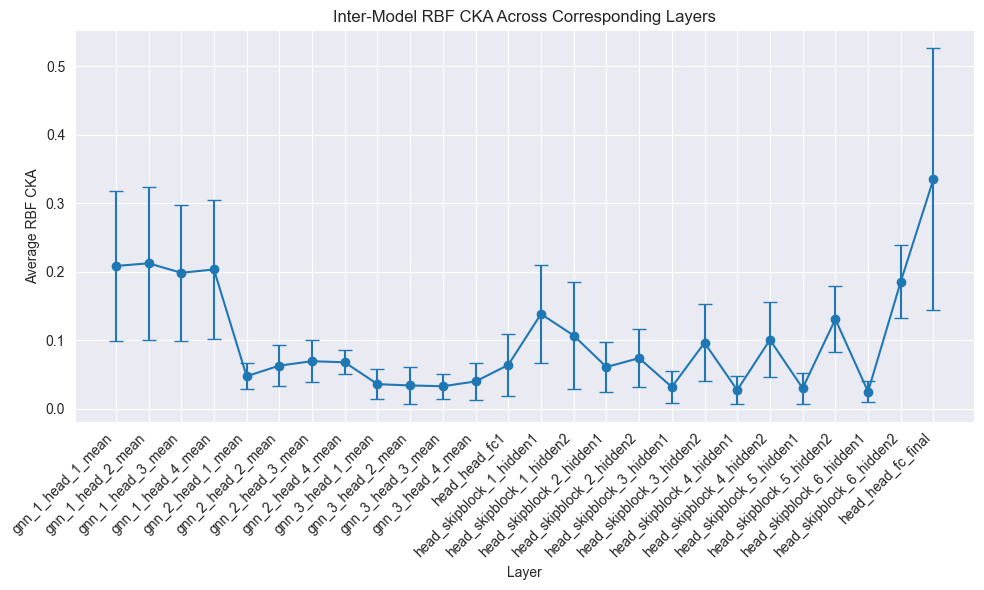

In [6]:
plot_inter_model_cka(layer_similarities_dreams, metric='rbf')

# Dreams Bonus

In [6]:
experiment_dreams_bonus = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_0_2025-02-19_17-38-07',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_1_2025-02-19_18-24-19',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_2_2025-02-19_19-10-33',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_3_2025-02-19_19-57-08'
]

In [8]:
layer_similarities_dreams_bonus = compute_inter_model_cka(experiment_dreams_bonus, layer_names, metric='rbf')

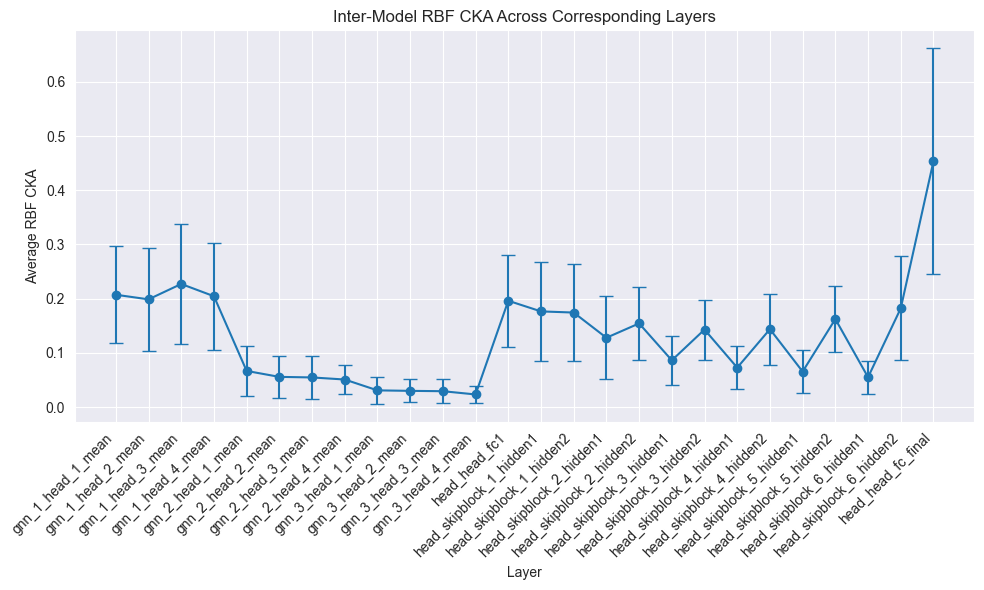

In [9]:
plot_inter_model_cka(layer_similarities_dreams_bonus, metric='rbf')

# Raw Spectra

In [7]:
experiment_raw_spectra = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_0_2025-02-19_09-00-57',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_1_2025-02-19_09-38-36',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_2_2025-02-19_10-20-04',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_3_2025-02-19_11-02-28'
]

In [11]:
layer_similarities_raw_spectra = compute_inter_model_cka(experiment_raw_spectra, layer_names, metric='rbf')

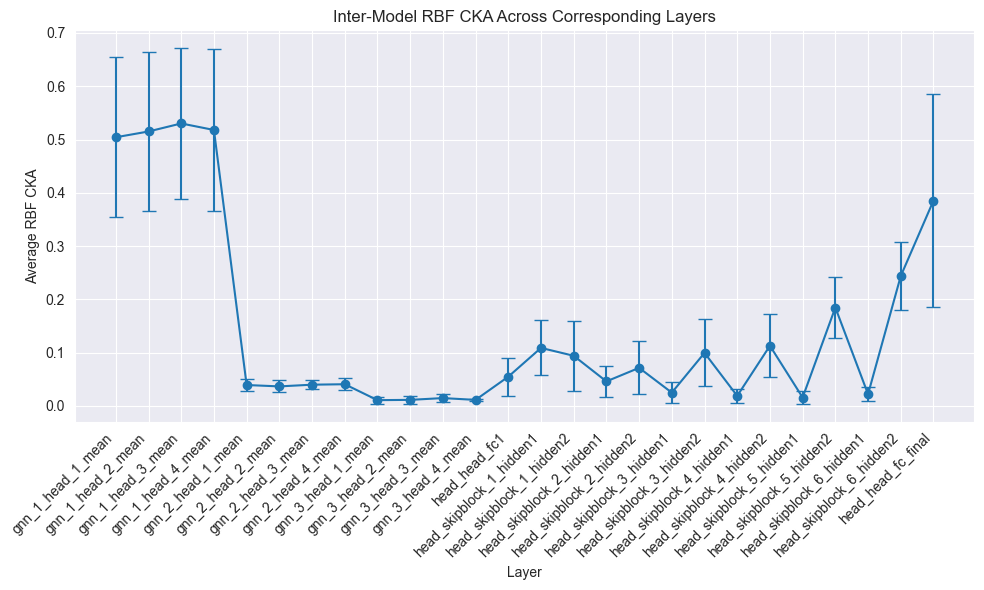

In [12]:
plot_inter_model_cka(layer_similarities_raw_spectra, metric='rbf')

# Raw Spectra Bonus

In [8]:
experiment_raw_spectra_bonus = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_0_2025-02-19_11-44-59',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_1_2025-02-19_12-31-04',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_2_2025-02-19_13-16-56',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_3_2025-02-19_14-04-53'
]

In [14]:
layer_similarities_raw_spectra_bonus = compute_inter_model_cka(experiment_raw_spectra_bonus, layer_names, metric='rbf')

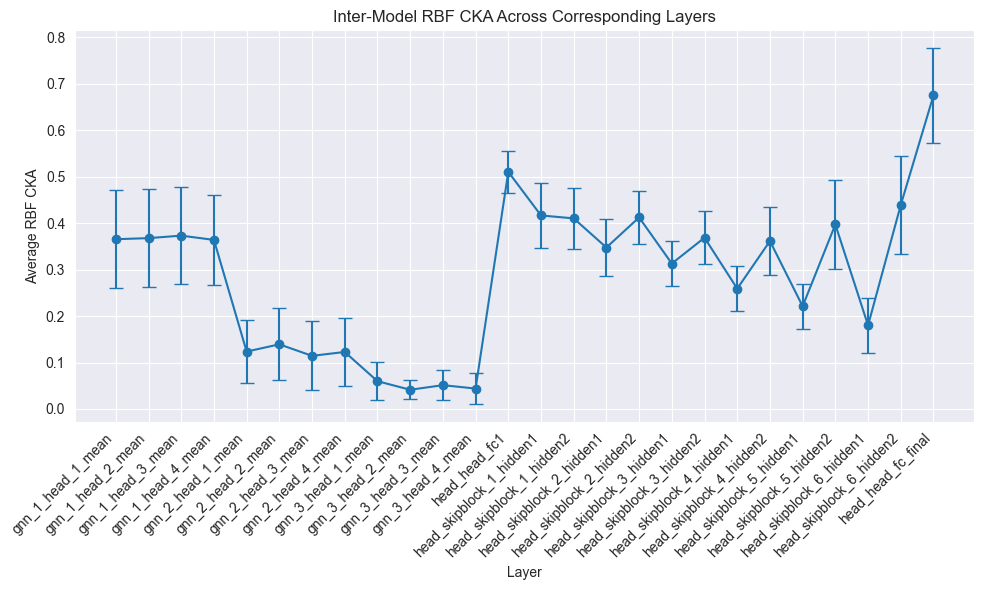

In [15]:
plot_inter_model_cka(layer_similarities_raw_spectra_bonus, metric='rbf')

# Aggregate by experiment

In [10]:
experiment_types = {
    "dreams": experiment_dreams,               # list of directories for dreams embeddings
    "dreams_bonus": experiment_dreams_bonus,     # list of directories for dreams bonus embeddings
    "raw_spectra": experiment_raw_spectra,         # list of directories for raw spectra
    "raw_spectra_bonus": experiment_raw_spectra_bonus  # list of directories for raw spectra plus bonus
}

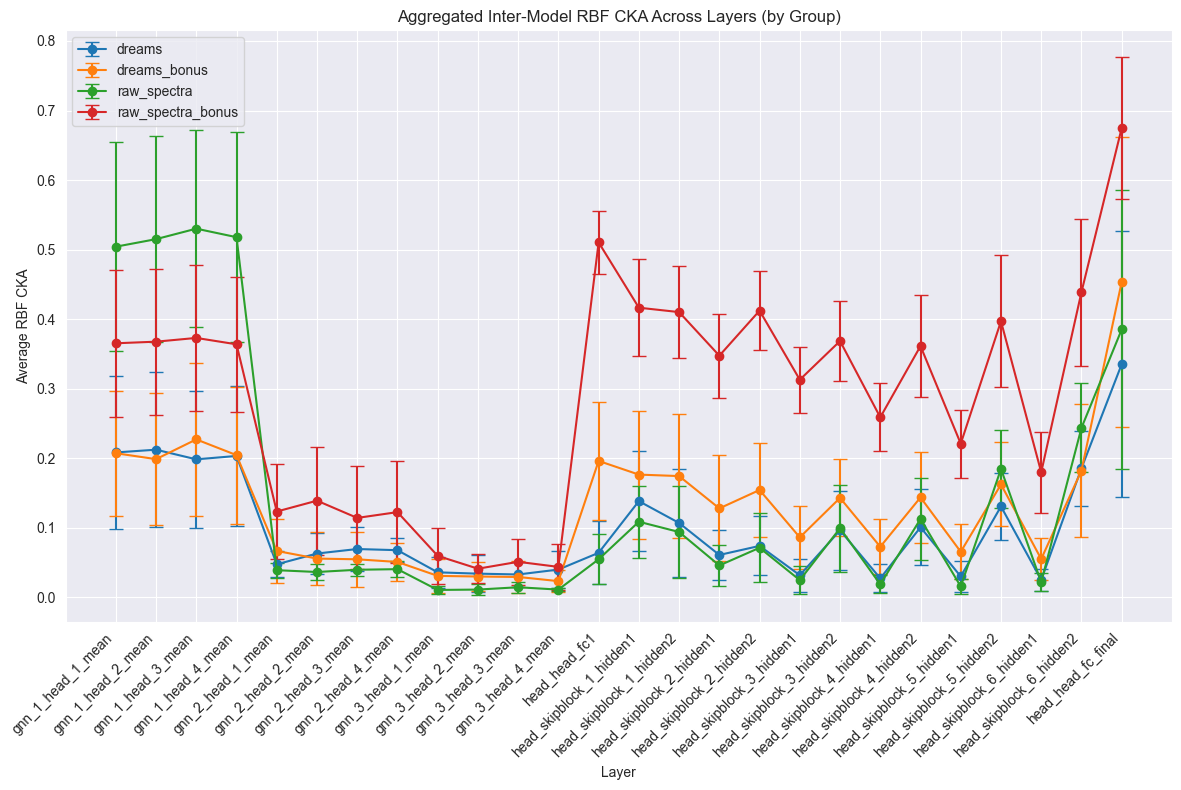

In [11]:
plot_aggregated_inter_model_cka_by_group(experiment_types, layer_names, metric='rbf')

# Errorbars by levels

## level 2

In [12]:
experiment_level_2 = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_0_2025-02-19_09-00-57',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_0_2025-02-19_11-44-59',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_0_2025-02-19_14-51-13',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_0_2025-02-19_17-38-07',
]

In [17]:
layer_similarities_level_2 = compute_inter_model_cka(experiment_level_2, layer_names, metric='rbf')

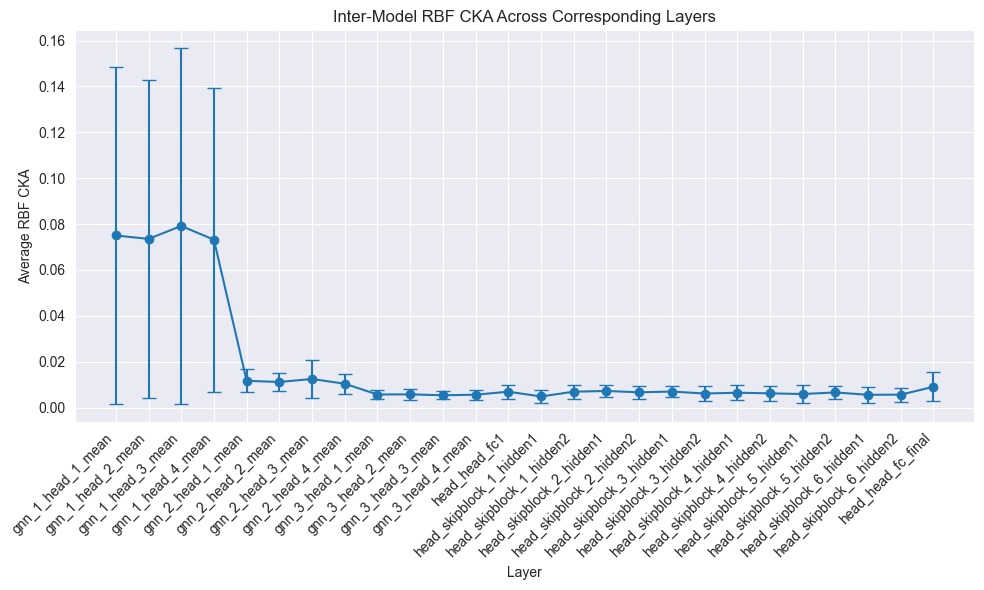

In [18]:
plot_inter_model_cka(layer_similarities_level_2, metric='rbf')

## level 3

In [13]:
experiment_level_3 = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_1_2025-02-19_09-38-36',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_1_2025-02-19_12-31-04',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_1_2025-02-19_15-31-19',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_1_2025-02-19_18-24-19',
]

In [20]:
layer_similarities_level_3 = compute_inter_model_cka(experiment_level_3, layer_names, metric='rbf')

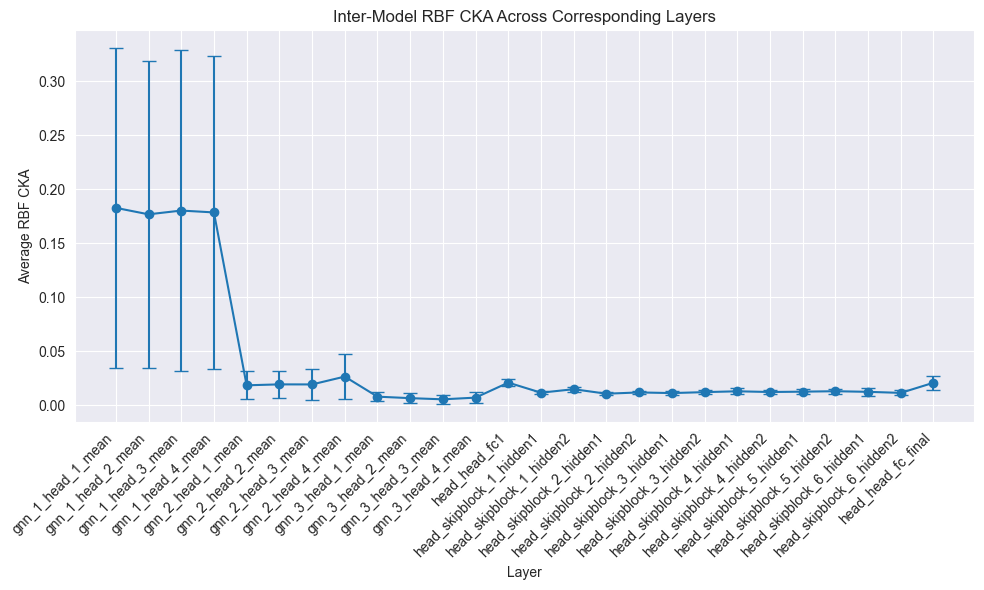

In [21]:
plot_inter_model_cka(layer_similarities_level_3, metric='rbf')

## level 4

In [14]:
experiment_level_4 = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_2_2025-02-19_10-20-04',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_2_2025-02-19_13-16-56',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_2_2025-02-19_16-12-30',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_2_2025-02-19_19-10-33',
]

In [23]:
layer_similarities_level_4 = compute_inter_model_cka(experiment_level_4, layer_names, metric='rbf')

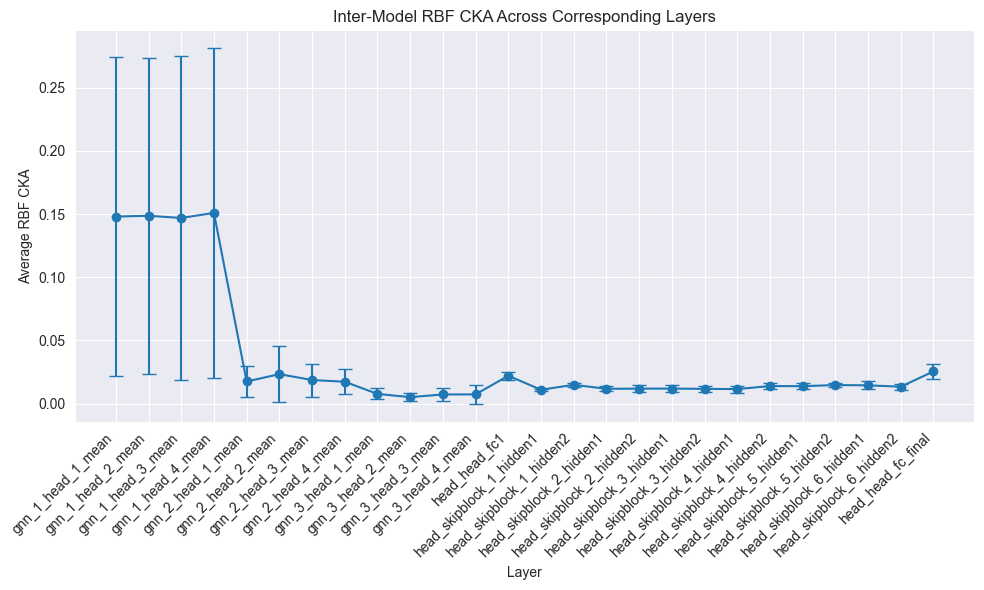

In [24]:
plot_inter_model_cka(layer_similarities_level_4, metric='rbf')

## level 5

In [15]:
experiment_level_5 = [
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_LUMI_cut_tree_3_2025-02-19_11-02-28',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_bonus_LUMI_cut_tree_3_2025-02-19_14-04-53',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_LUMI_cut_tree_3_2025-02-19_16-56-31',
    '/Users/macbook/CODE/PhantoMS/data/retrieval_trained/cut_tree_COSINE/config_skip_connection_dreams_bonus_LUMI_cut_tree_3_2025-02-19_19-57-08',
]

In [26]:
layer_similarities_level_5 = compute_inter_model_cka(experiment_level_5, layer_names, metric='rbf')

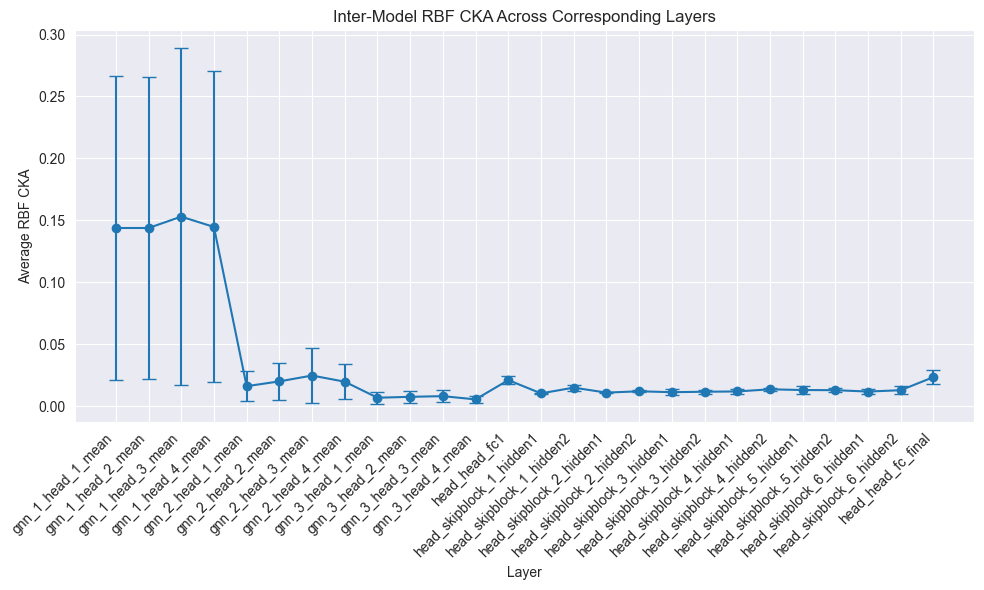

In [27]:
plot_inter_model_cka(layer_similarities_level_5, metric='rbf')

# Aggregate by level

In [16]:
experiment_levels = {
    "ms2": experiment_level_2,  
    "ms3": experiment_level_3,
    "ms4": experiment_level_4,
    "ms5": experiment_level_5
}

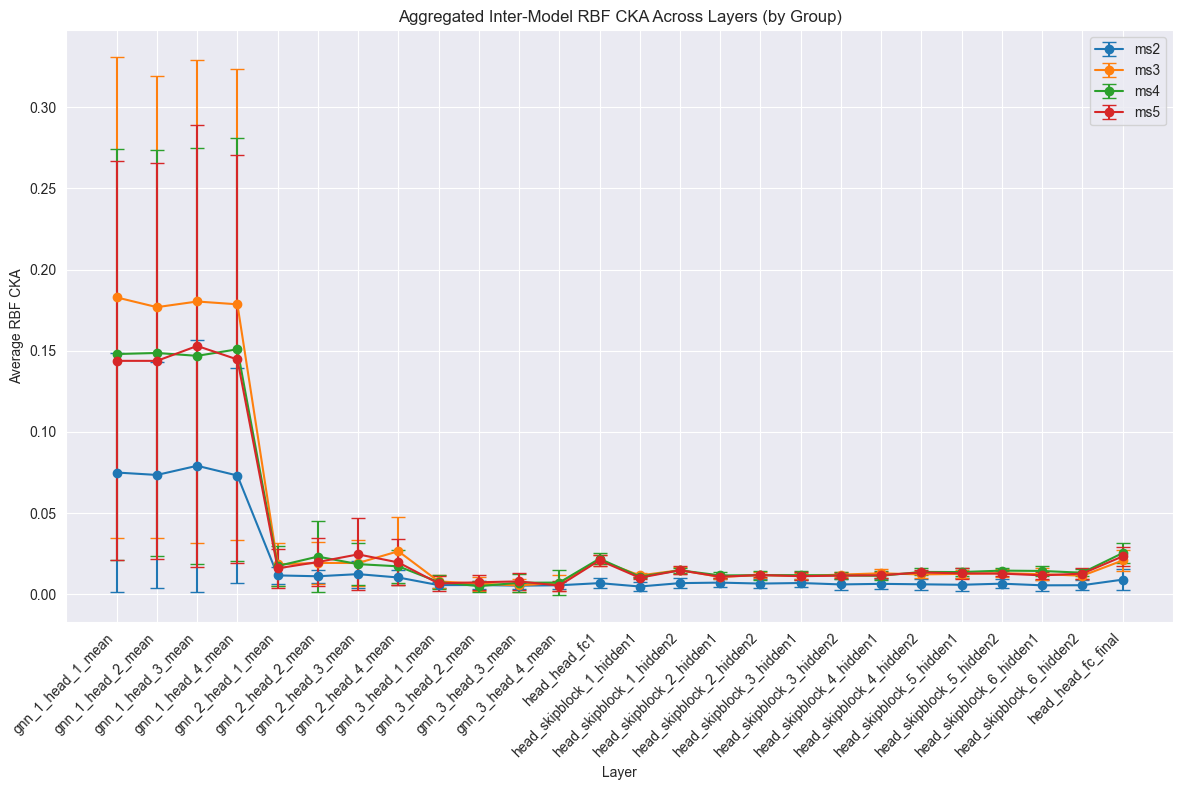

In [17]:
plot_aggregated_inter_model_cka_by_group(experiment_levels, layer_names, metric='rbf')